## Klassifisering av matretter 1

I denne leksjonen skal vi utforske ulike klassifiseringsmetoder for å *forutsi en nasjonal matrett basert på en gruppe ingredienser.* Samtidig skal vi lære mer om hvordan algoritmer kan brukes til klassifiseringsoppgaver.

### [**Quiz før leksjonen**](https://gray-sand-07a10f403.1.azurestaticapps.net/quiz/21/)

### **Forberedelse**

Denne leksjonen bygger videre på vår [forrige leksjon](https://github.com/microsoft/ML-For-Beginners/blob/main/4-Classification/1-Introduction/solution/lesson_10-R.ipynb) der vi:

-   Ga en enkel introduksjon til klassifisering ved hjelp av et datasett om alle de fantastiske matrettene fra Asia og India 😋.

-   Utforsket noen [dplyr-kommandoer](https://dplyr.tidyverse.org/) for å klargjøre og rense dataene våre.

-   Lagde vakre visualiseringer med ggplot2.

-   Viste hvordan man håndterer ubalanserte data ved å forhåndsbehandle dem med [recipes](https://recipes.tidymodels.org/articles/Simple_Example.html).

-   Demonstrerte hvordan man bruker `prep` og `bake` for å bekrefte at oppskriften fungerer som den skal.

#### **Forutsetninger**

For denne leksjonen trenger vi følgende pakker for å rense, klargjøre og visualisere dataene våre:

-   `tidyverse`: [tidyverse](https://www.tidyverse.org/) er en [samling av R-pakker](https://www.tidyverse.org/packages) designet for å gjøre datavitenskap raskere, enklere og morsommere!

-   `tidymodels`: [tidymodels](https://www.tidymodels.org/) er et [rammeverk med pakker](https://www.tidymodels.org/packages/) for modellering og maskinlæring.

-   `themis`: [themis-pakken](https://themis.tidymodels.org/) gir ekstra oppskritt for å håndtere ubalanserte data.

-   `nnet`: [nnet-pakken](https://cran.r-project.org/web/packages/nnet/nnet.pdf) tilbyr funksjoner for å estimere feed-forward nevrale nettverk med ett skjult lag, samt for modeller for multinomial logistisk regresjon.

Du kan installere dem slik:


`install.packages(c("tidyverse", "tidymodels", "DataExplorer", "here"))`

Alternativt sjekker skriptet nedenfor om du har de nødvendige pakkene for å fullføre denne modulen, og installerer dem for deg hvis de mangler.


In [2]:
suppressWarnings(if (!require("pacman"))install.packages("pacman"))

pacman::p_load(tidyverse, tidymodels, themis, here)

Loading required package: pacman



## 1. Del dataene inn i trenings- og testsett.

Vi starter med å velge noen få steg fra vår forrige leksjon.

### Fjern de vanligste ingrediensene som skaper forvirring mellom ulike kjøkken, ved hjelp av `dplyr::select()`.

Alle elsker ris, hvitløk og ingefær!


In [3]:
# Load the original cuisines data
df <- read_csv(file = "https://raw.githubusercontent.com/microsoft/ML-For-Beginners/main/4-Classification/data/cuisines.csv")

# Drop id column, rice, garlic and ginger from our original data set
df_select <- df %>% 
  select(-c(1, rice, garlic, ginger)) %>%
  # Encode cuisine column as categorical
  mutate(cuisine = factor(cuisine))

# Display new data set
df_select %>% 
  slice_head(n = 5)

# Display distribution of cuisines
df_select %>% 
  count(cuisine) %>% 
  arrange(desc(n))

New names:
* `` -> ...1

Rows: 2448 Columns: 385

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): cuisine
dbl (384): ...1, almond, angelica, anise, anise_seed, apple, apple_brandy, a...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 indian  0      0        0     0          0     0            0       0       
2 indian  1      0        0     0          0     0            0       0       
3 indian  0      0        0     0          0     0            0       0       
4 indian  0      0        0     0          0     0            0       0       
5 indian  0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       0    0   
2 0         ⋯ 0       0           0          0                       0    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     1      0

cuisine  n  
1 korean   799
2 indian   598
3 chinese  442
4 japanese 320
5 thai     289

Perfekt! Nå er det på tide å dele dataene slik at 70 % av dataene går til trening og 30 % til testing. Vi vil også bruke en `stratifisering`-teknikk når vi deler dataene for å `bevare andelen av hver matkultur` i trenings- og valideringsdatasett.

[rsample](https://rsample.tidymodels.org/), en pakke i Tidymodels, gir infrastruktur for effektiv deling og resampling av data:


In [4]:
# Load the core Tidymodels packages into R session
library(tidymodels)

# Create split specification
set.seed(2056)
cuisines_split <- initial_split(data = df_select,
                                strata = cuisine,
                                prop = 0.7)

# Extract the data in each split
cuisines_train <- training(cuisines_split)
cuisines_test <- testing(cuisines_split)

# Print the number of cases in each split
cat("Training cases: ", nrow(cuisines_train), "\n",
    "Test cases: ", nrow(cuisines_test), sep = "")

# Display the first few rows of the training set
cuisines_train %>% 
  slice_head(n = 5)


# Display distribution of cuisines in the training set
cuisines_train %>% 
  count(cuisine) %>% 
  arrange(desc(n))

Training cases: 1712
Test cases: 736

cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 chinese 0      0        0     0          0     0            0       0       
2 chinese 0      0        0     0          0     0            0       0       
3 chinese 0      0        0     0          0     0            0       0       
4 chinese 0      0        0     0          0     0            0       0       
5 chinese 0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       1    0   
2 0         ⋯ 0       0           0          0                       1    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     0      0

cuisine  n  
1 korean   559
2 indian   418
3 chinese  309
4 japanese 224
5 thai     202

## 2. Håndtere ubalanserte data

Som du kanskje har lagt merke til i det opprinnelige datasettet, så vel som i treningssettet vårt, er det en ganske ujevn fordeling i antall kjøkken. Koreanske kjøkken er *nesten* 3 ganger så mange som thailandske kjøkken. Ubalanserte data har ofte negative effekter på modellens ytelse. Mange modeller fungerer best når antall observasjoner er likt, og har derfor en tendens til å slite med ubalanserte data.

Det finnes hovedsakelig to måter å håndtere ubalanserte datasett på:

-   legge til observasjoner i minoritetsklassen: `Over-sampling`, for eksempel ved å bruke en SMOTE-algoritme som syntetisk genererer nye eksempler av minoritetsklassen ved hjelp av nærmeste naboer til disse tilfellene.

-   fjerne observasjoner fra majoritetsklassen: `Under-sampling`

I vår forrige leksjon demonstrerte vi hvordan man kan håndtere ubalanserte datasett ved hjelp av en `recipe`. En recipe kan betraktes som en oppskrift som beskriver hvilke steg som skal brukes på et datasett for å gjøre det klart for dataanalyse. I vårt tilfelle ønsker vi å ha en lik fordeling i antall kjøkken i vårt `treningssett`. La oss sette i gang!


In [5]:
# Load themis package for dealing with imbalanced data
library(themis)

# Create a recipe for preprocessing training data
cuisines_recipe <- recipe(cuisine ~ ., data = cuisines_train) %>% 
  step_smote(cuisine)

# Print recipe
cuisines_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor        380

Operations:

SMOTE based on cuisine

Du kan selvfølgelig gå videre og bekrefte (ved å forberede og bake) at oppskriften fungerer som forventet - alle matetikettene har `559` observasjoner.

Siden vi skal bruke denne oppskriften som en forprosessering for modellering, vil en `workflow()` ta seg av all forberedelse og baking for oss, så vi slipper å estimere oppskriften manuelt.

Nå er vi klare til å trene en modell 👩‍💻👨‍💻!

## 3. Velge din klassifikator

<p >
   <img src="../../images/parsnip.jpg"
   width="600"/>
   <figcaption>Kunstverk av @allison_horst</figcaption>


Nå må vi bestemme oss for hvilken algoritme vi skal bruke til oppgaven 🤔.

I Tidymodels gir [`parsnip-pakken`](https://parsnip.tidymodels.org/index.html) en konsekvent grensesnitt for å jobbe med modeller på tvers av ulike motorer (pakker). Se dokumentasjonen for parsnip for å utforske [modelltyper og motorer](https://www.tidymodels.org/find/parsnip/#models) og deres tilhørende [modellargumenter](https://www.tidymodels.org/find/parsnip/#model-args). Utvalget kan virke ganske overveldende ved første øyekast. For eksempel inkluderer følgende metoder klassifiseringsteknikker:

-   C5.0 Regelbaserte klassifiseringsmodeller

-   Fleksible diskriminantmodeller

-   Lineære diskriminantmodeller

-   Regulariserte diskriminantmodeller

-   Logistiske regresjonsmodeller

-   Multinomiale regresjonsmodeller

-   Naive Bayes-modeller

-   Støttevektormaskiner

-   Nærmeste naboer

-   Beslutningstrær

-   Ensemble-metoder

-   Nevrale nettverk

Listen fortsetter!

### **Hvilken klassifikator skal vi velge?**

Så, hvilken klassifikator bør du velge? Ofte er det en god idé å teste flere og se etter et godt resultat.

> AutoML løser dette problemet elegant ved å kjøre disse sammenligningene i skyen, slik at du kan velge den beste algoritmen for dine data. Prøv det [her](https://docs.microsoft.com/learn/modules/automate-model-selection-with-azure-automl/?WT.mc_id=academic-77952-leestott)

Valget av klassifikator avhenger også av problemet vårt. For eksempel, når utfallet kan kategoriseres i `mer enn to klasser`, som i vårt tilfelle, må du bruke en `multiklasse klassifikasjonsalgoritme` i stedet for `binær klassifikasjon.`

### **En bedre tilnærming**

En bedre tilnærming enn å gjette vilt er å følge ideene i dette nedlastbare [ML Cheat Sheet](https://docs.microsoft.com/azure/machine-learning/algorithm-cheat-sheet?WT.mc_id=academic-77952-leestott). Her oppdager vi at, for vårt multiklasseproblem, har vi noen valg:

<p >
   <img src="../../images/cheatsheet.png"
   width="500"/>
   <figcaption>En del av Microsofts Algorithm Cheat Sheet, som viser alternativer for multiklasse klassifikasjon</figcaption>


### **Resonnement**

La oss se om vi kan resonnere oss fram til ulike tilnærminger gitt de begrensningene vi har:

-   **Dype nevrale nettverk er for tunge**. Gitt vårt rene, men minimale datasett, og det faktum at vi kjører trening lokalt via notatbøker, er dype nevrale nettverk for tunge for denne oppgaven.

-   **Ingen to-klassers klassifikator**. Vi bruker ikke en to-klassers klassifikator, så det utelukker one-vs-all.

-   **Beslutningstre eller logistisk regresjon kan fungere**. Et beslutningstre kan fungere, eller multinomial regresjon/multiklass logistisk regresjon for multiklass-data.

-   **Multiklass Boosted Decision Trees løser et annet problem**. Multiklass Boosted Decision Trees er mest egnet for ikke-parametriske oppgaver, f.eks. oppgaver designet for å bygge rangeringer, så det er ikke nyttig for oss.

Vanligvis, før man går i gang med mer komplekse maskinlæringsmodeller som ensemble-metoder, er det en god idé å bygge den enkleste mulige modellen for å få en idé om hva som skjer. Så for denne leksjonen starter vi med en `multinomial regresjonsmodell`.

> Logistisk regresjon er en teknikk som brukes når utfallsvariabelen er kategorisk (eller nominell). For binær logistisk regresjon er antall utfallsvariabler to, mens antall utfallsvariabler for multinomial logistisk regresjon er mer enn to. Se [Avanserte regresjonsmetoder](https://bookdown.org/chua/ber642_advanced_regression/multinomial-logistic-regression.html) for mer informasjon.

## 4. Tren og evaluer en Multinomial logistisk regresjonsmodell.

I Tidymodels definerer `parsnip::multinom_reg()` en modell som bruker lineære prediktorer for å forutsi multiklass-data ved hjelp av multinomial fordeling. Se `?multinom_reg()` for de ulike måtene/motorene du kan bruke for å tilpasse denne modellen.

For dette eksempelet skal vi tilpasse en Multinomial regresjonsmodell via standardmotoren [nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf).

> Jeg valgte en verdi for `penalty` litt tilfeldig. Det finnes bedre måter å velge denne verdien på, nemlig ved å bruke `resampling` og `tuning` av modellen, som vi skal diskutere senere.
>
> Se [Tidymodels: Kom i gang](https://www.tidymodels.org/start/tuning/) hvis du vil lære mer om hvordan du tuner modellens hyperparametere.


In [6]:
# Create a multinomial regression model specification
mr_spec <- multinom_reg(penalty = 1) %>% 
  set_engine("nnet", MaxNWts = 2086) %>% 
  set_mode("classification")

# Print model specification
mr_spec

Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Flott jobb 🥳! Nå som vi har en oppskrift og en modellspesifikasjon, må vi finne en måte å samle dem sammen i et objekt som først vil forhåndsbehandle dataene, deretter tilpasse modellen på de forhåndsbehandlede dataene, og også tillate potensielle etterbehandlingsaktiviteter. I Tidymodels kalles dette praktiske objektet en [`workflow`](https://workflows.tidymodels.org/) og holder praktisk dine modelleringskomponenter! Dette er det vi ville kalt *pipelines* i *Python*.

Så la oss samle alt i en workflow!📦


In [7]:
# Bundle recipe and model specification
mr_wf <- workflow() %>% 
  add_recipe(cuisines_recipe) %>% 
  add_model(mr_spec)

# Print out workflow
mr_wf

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Arbeidsflyter 👌👌! En **`workflow()`** kan tilpasses på omtrent samme måte som en modell kan. Så, tid for å trene en modell!


In [8]:
# Train a multinomial regression model
mr_fit <- fit(object = mr_wf, data = cuisines_train)

mr_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Call:
nnet::multinom(formula = ..y ~ ., data = data, decay = ~1, MaxNWts = ~2086, 
    trace = FALSE)

Coefficients:
         (Intercept)     almond angelica         anise anise_seed       apple
indian    0.19723325  0.2409661        0 -5.004955e-05 -0.1657635 -0.05769734
japanese  0.13961959 -0.6262400        0 -1.169155e-04 -0.4893596 -0.08585717
korean    0.22377347 -0.1833485        0 -5.560395e-05 -0.2489401 -0.15657804
thai     -0.04336577 -0.6106258        0  4.903828e-04 -0.5782866  0.63451105
         apple_brandy     apricot armagnac   artemisia artichoke   asparagus
indian              0  0.37042636        0 -0.09122797         0 -0.27181970
japanese            0

Utdataene viser koeffisientene som modellen lærte under treningen.

### Evaluere den trente modellen

Det er på tide å se hvordan modellen presterte 📏 ved å evaluere den på et testsett! La oss starte med å gjøre prediksjoner på testsettet.


In [9]:
# Make predictions on the test set
results <- cuisines_test %>% select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test))

# Print out results
results %>% 
  slice_head(n = 5)

cuisine .pred_class
1 indian  thai       
2 indian  indian     
3 indian  indian     
4 indian  indian     
5 indian  indian

Flott jobb! I Tidymodels kan evaluering av modellprestasjon gjøres ved hjelp av [yardstick](https://yardstick.tidymodels.org/) - en pakke som brukes til å måle effektiviteten av modeller ved hjelp av ytelsesmetrikker. Som vi gjorde i vår leksjon om logistisk regresjon, la oss begynne med å beregne en forvirringsmatrise.


In [10]:
# Confusion matrix for categorical data
conf_mat(data = results, truth = cuisine, estimate = .pred_class)


          Truth
Prediction chinese indian japanese korean thai
  chinese       83      1        8     15   10
  indian         4    163        1      2    6
  japanese      21      5       73     25    1
  korean        15      0       11    191    0
  thai          10     11        3      7   70

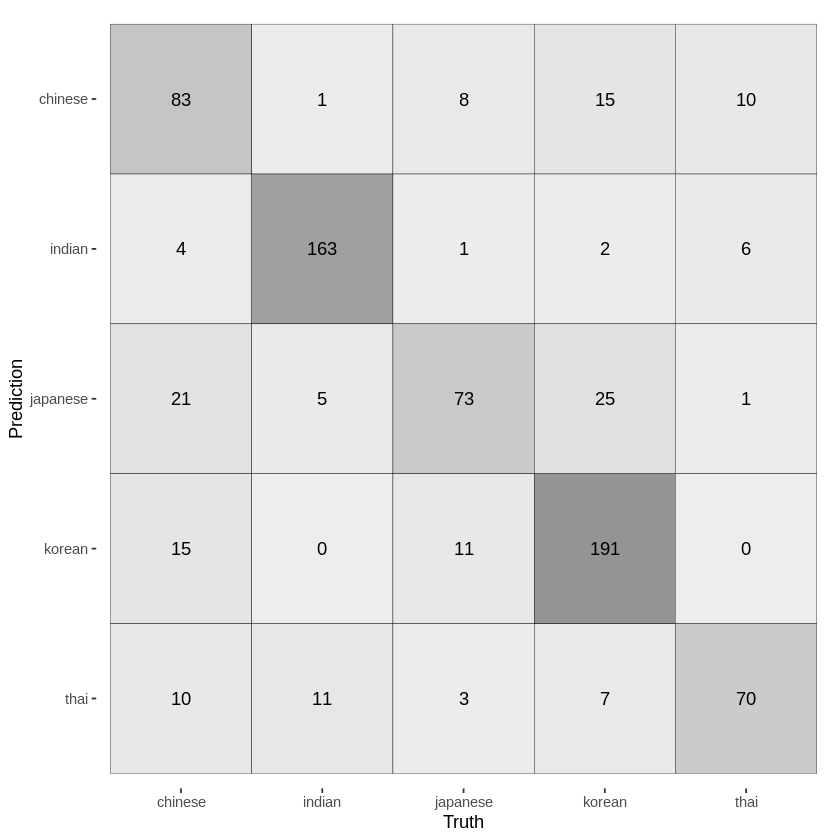

In [11]:
update_geom_defaults(geom = "tile", new = list(color = "black", alpha = 0.7))
# Visualize confusion matrix
results %>% 
  conf_mat(cuisine, .pred_class) %>% 
  autoplot(type = "heatmap")

De mørkere rutene i forvirringsmatrisen indikerer et høyt antall tilfeller, og du kan forhåpentligvis se en diagonal linje med mørkere ruter som viser tilfeller der den predikerte og faktiske etiketten er den samme.

La oss nå beregne oppsummeringsstatistikk for forvirringsmatrisen.


In [12]:
# Summary stats for confusion matrix
conf_mat(data = results, truth = cuisine, estimate = .pred_class) %>% 
summary()

.metric              .estimator .estimate
1  accuracy             multiclass 0.7880435
2  kap                  multiclass 0.7276583
3  sens                 macro      0.7780927
4  spec                 macro      0.9477598
5  ppv                  macro      0.7585583
6  npv                  macro      0.9460080
7  mcc                  multiclass 0.7292724
8  j_index              macro      0.7258524
9  bal_accuracy         macro      0.8629262
10 detection_prevalence macro      0.2000000
11 precision            macro      0.7585583
12 recall               macro      0.7780927
13 f_meas               macro      0.7641862

Hvis vi ser nærmere på noen målinger som nøyaktighet, sensitivitet, ppv, er vi ikke så verst i gang 🥳!

## 4. Gå dypere

La oss stille et subtilt spørsmål: Hvilke kriterier brukes for å avgjøre hvilken type mat som blir den predikerte utfallet?

Vel, statistiske maskinlæringsalgoritmer, som logistisk regresjon, er basert på `sannsynlighet`; så det som faktisk blir predikert av en klassifiserer er en sannsynlighetsfordeling over et sett av mulige utfall. Klassen med høyest sannsynlighet blir deretter valgt som det mest sannsynlige utfallet for de gitte observasjonene.

La oss se dette i praksis ved å lage både harde klasseprediksjoner og sannsynligheter.


In [13]:
# Make hard class prediction and probabilities
results_prob <- cuisines_test %>%
  select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test)) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test, type = "prob"))

# Print out results
results_prob %>% 
  slice_head(n = 5)

cuisine .pred_class .pred_chinese .pred_indian .pred_japanese .pred_korean
1 indian  thai        1.551259e-03  0.4587877    5.988039e-04   2.428503e-04
2 indian  indian      2.637133e-05  0.9999488    6.648651e-07   2.259993e-05
3 indian  indian      1.049433e-03  0.9909982    1.060937e-03   1.644947e-05
4 indian  indian      6.237482e-02  0.4763035    9.136702e-02   3.660913e-01
5 indian  indian      1.431745e-02  0.9418551    2.945239e-02   8.721782e-03
  .pred_thai  
1 5.388194e-01
2 1.577948e-06
3 6.874989e-03
4 3.863391e-03
5 5.653283e-03

✅ Kan du forklare hvorfor modellen er ganske sikker på at den første observasjonen er thai?

## **🚀Utfordring**

I denne leksjonen brukte du de rensede dataene dine til å bygge en maskinlæringsmodell som kan forutsi en nasjonal matkultur basert på en rekke ingredienser. Ta deg tid til å lese gjennom de [mange alternativene](https://www.tidymodels.org/find/parsnip/#models) som Tidymodels tilbyr for å klassifisere data og [andre måter](https://parsnip.tidymodels.org/articles/articles/Examples.html#multinom_reg-models) å tilpasse multinomial regresjon.

#### TAKK TIL:

[`Allison Horst`](https://twitter.com/allison_horst/) for å lage de fantastiske illustrasjonene som gjør R mer innbydende og engasjerende. Finn flere illustrasjoner i hennes [galleri](https://www.google.com/url?q=https://github.com/allisonhorst/stats-illustrations&sa=D&source=editors&ust=1626380772530000&usg=AOvVaw3zcfyCizFQZpkSLzxiiQEM).

[Cassie Breviu](https://www.twitter.com/cassieview) og [Jen Looper](https://www.twitter.com/jenlooper) for å lage den originale Python-versjonen av denne modulen ♥️

<br>
Skulle gjerne ha slengt inn noen vitser, men jeg skjønner ikke matordspill 😅.

<br>

Lykke til med læringen,

[Eric](https://twitter.com/ericntay), Gold Microsoft Learn Student Ambassador.



---

**Ansvarsfraskrivelse**:  
Dette dokumentet er oversatt ved hjelp av AI-oversettelsestjenesten [Co-op Translator](https://github.com/Azure/co-op-translator). Selv om vi tilstreber nøyaktighet, vennligst vær oppmerksom på at automatiske oversettelser kan inneholde feil eller unøyaktigheter. Det originale dokumentet på sitt opprinnelige språk bør anses som den autoritative kilden. For kritisk informasjon anbefales profesjonell menneskelig oversettelse. Vi er ikke ansvarlige for eventuelle misforståelser eller feiltolkninger som oppstår ved bruk av denne oversettelsen.
